# Diagnóstico de Overfitting - Caria Models

Este notebook evalúa los modelos `.pkl` (quality, valuation, momentum) y el modelo PyTorch Lightning para detectar overfitting comparando métricas entre train/val/test.

## Pasos:
1. Instalar dependencias
2. Montar Google Drive
3. Cargar datos y modelos
4. Evaluar modelos
5. Generar reporte


## 1. Instalar Dependencias


In [1]:
# Instalar dependencias necesarias
!pip install -q pandas numpy scikit-learn xgboost lightgbm joblib pyarrow pyyaml


In [2]:
# Instalar PyTorch Lightning (opcional, para evaluar SimpleFusionModel)
!pip install -q pytorch-lightning torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.3 MB/s eta 0:00:00


## 2. Montar Google Drive


In [3]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Configurar ruta base donde están tus datos
# AJUSTA ESTA RUTA según donde subiste los archivos en Drive
DRIVE_BASE_PATH = '/content/drive/MyDrive/caria_data'  # Cambia esto a tu ruta

# Verificar que existe
if os.path.exists(DRIVE_BASE_PATH):
    print(f"✓ Ruta encontrada: {DRIVE_BASE_PATH}")
    print(f"Contenido:")
    for item in os.listdir(DRIVE_BASE_PATH):
        print(f"  - {item}")
else:
    print(f"⚠ Ruta no encontrada: {DRIVE_BASE_PATH}")
    print("Por favor ajusta DRIVE_BASE_PATH a la ubicación de tus datos")


Mounted at /content/drive
✓ Ruta encontrada: /content/drive/MyDrive/caria_data
Contenido:
  - data
  - models
  - artifacts
  - diagnostic_overfitting_colab.ipynb


## 3. Configurar Rutas y Crear Estructura


In [6]:
from pathlib import Path
import shutil

# Crear estructura de directorios en Colab
BASE_DIR = Path('/content/caria_workspace')
BASE_DIR.mkdir(exist_ok=True)

# Directorios necesarios
(BASE_DIR / 'data' / 'gold').mkdir(parents=True, exist_ok=True)
(BASE_DIR / 'models').mkdir(parents=True, exist_ok=True)
(BASE_DIR / 'artifacts' / 'diagnostics').mkdir(parents=True, exist_ok=True)

print(f"Estructura creada en: {BASE_DIR}")

# Copiar archivos desde Drive (ajusta las rutas según tu estructura)
drive_data_path = Path(DRIVE_BASE_PATH)

# Copiar archivos parquet de gold
for split in ['train', 'val', 'test']:
    src = drive_data_path / 'data' / 'gold' / f'{split}.parquet'
    dst = BASE_DIR / 'data' / 'gold' / f'{split}.parquet'
    if src.exists():
        shutil.copy2(src, dst)
        print(f"✓ Copiado: {split}.parquet ({dst.stat().st_size / 1024 / 1024:.2f} MB)")
    else:
        print(f"⚠ No encontrado: {src}")

# Copiar modelos .pkl
for model_name in ['quality_model', 'valuation_model', 'momentum_model', 'feature_config']:
    src = drive_data_path / 'models' / f'{model_name}.pkl'
    dst = BASE_DIR / 'models' / f'{model_name}.pkl'
    if src.exists():
        shutil.copy2(src, dst)
        print(f"✓ Copiado: {model_name}.pkl")
    else:
        print(f"⚠ No encontrado: {src}")

# Copiar checkpoint de PyTorch (opcional)
checkpoint_src = drive_data_path / 'artifacts' / 'models' / 'epoch=20-val_loss=0.0038.ckpt'
if checkpoint_src.exists():
    checkpoint_dst = BASE_DIR / 'artifacts' / 'models' / checkpoint_src.name
    checkpoint_dst.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(checkpoint_src, checkpoint_dst)
    print(f"✓ Copiado checkpoint: {checkpoint_src.name}")
else:
    print(f"⚠ Checkpoint no encontrado (opcional)")


Estructura creada en: /content/caria_workspace
✓ Copiado: train.parquet (436.82 MB)
✓ Copiado: val.parquet (60.07 MB)
✓ Copiado: test.parquet (39.54 MB)
✓ Copiado: quality_model.pkl
✓ Copiado: valuation_model.pkl
✓ Copiado: momentum_model.pkl
✓ Copiado: feature_config.pkl
✓ Copiado checkpoint: epoch=20-val_loss=0.0038.ckpt


In [7]:
import json
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
)

# Intentar importar PyTorch Lightning
try:
    import pytorch_lightning as pl
    HAS_PYTORCH = True
    print("✓ PyTorch Lightning disponible")
except ImportError:
    HAS_PYTORCH = False
    print("⚠ PyTorch Lightning no disponible - solo modelos .pkl serán evaluados")


def evaluate_pkl_model(
    model_path: Path,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    is_classifier: bool = False,
) -> dict[str, dict[str, float]]:
    """Evalúa un modelo .pkl en train/val/test."""
    model = joblib.load(model_path)
    results: dict[str, dict[str, float]] = {}

    for split_name, X, y in [
        ("train", X_train, y_train),
        ("val", X_val, y_val),
        ("test", X_test, y_test),
    ]:
        if X.empty or y.empty:
            continue

        y_pred = model.predict(X)
        if is_classifier:
            y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else y_pred
            results[split_name] = {
                "accuracy": float(accuracy_score(y, y_pred)),
                "auc_roc": float(roc_auc_score(y, y_pred_proba)) if len(np.unique(y)) > 1 else 0.0,
            }
        else:
            results[split_name] = {
                "rmse": float(np.sqrt(mean_squared_error(y, y_pred))),
                "mae": float(mean_absolute_error(y, y_pred)),
                "r2": float(r2_score(y, y_pred)),
            }

    return results


def calculate_gaps(metrics: dict[str, dict[str, float]]) -> dict[str, dict[str, float]]:
    """Calcula gaps entre splits."""
    gaps: dict[str, dict[str, float]] = {}

    if "train" in metrics and "val" in metrics:
        train_val_gaps = {}
        for metric in metrics["train"]:
            if metric in metrics["val"]:
                train_val_gaps[f"train_val_gap_{metric}"] = (
                    metrics["train"][metric] - metrics["val"][metric]
                )
        gaps["train_val"] = train_val_gaps

    if "val" in metrics and "test" in metrics:
        val_test_gaps = {}
        for metric in metrics["val"]:
            if metric in metrics["test"]:
                val_test_gaps[f"val_test_gap_{metric}"] = (
                    metrics["val"][metric] - metrics["test"][metric]
                )
        gaps["val_test"] = val_test_gaps

    if "train" in metrics and "test" in metrics:
        train_test_gaps = {}
        for metric in metrics["train"]:
            if metric in metrics["test"]:
                train_test_gaps[f"train_test_gap_{metric}"] = (
                    metrics["train"][metric] - metrics["test"][metric]
                )
        gaps["train_test"] = train_test_gaps

    return gaps


def prepare_pkl_features(
    df: pd.DataFrame,
    model_path: Path,
    feature_config: dict | None = None,
    model_name: str | None = None,
) -> tuple[pd.DataFrame, pd.Series]:
    """Prepara features y target para modelos .pkl."""
    # Obtener features del modelo
    expected_features = None
    if model_path.exists():
        try:
            model = joblib.load(model_path)
            if hasattr(model, "feature_names_in_"):
                expected_features = list(model.feature_names_in_)
            elif hasattr(model, "get_booster"):
                try:
                    booster = model.get_booster()
                    if hasattr(booster, "feature_names"):
                        expected_features = booster.feature_names
                except:
                    pass
        except:
            pass

    # Si no se pueden obtener del modelo, usar feature_config
    if expected_features is None and feature_config:
        if model_name == "quality_model":
            expected_features = feature_config.get("quality_features", [])
        elif model_name == "valuation_model":
            expected_features = feature_config.get("valuation_features", [])
        elif model_name == "momentum_model":
            expected_features = feature_config.get("momentum_features", [])

    # Si aún no tenemos features, usar todas las numéricas disponibles
    if expected_features is None:
        exclude_cols = {
            "ticker",
            "date",
            "target",
            "target_return_20d",
            "target_drawdown_prob",
            "target_regime",
            "features",
            "feature_columns",
            "regime_name",
            "period",
        }
        expected_features = [col for col in df.columns if col not in exclude_cols]

    # Filtrar solo las features que existen
    available_features = [f for f in expected_features if f in df.columns]
    missing_features = [f for f in expected_features if f not in df.columns]

    if missing_features:
        print(f"    [WARNING] Features faltantes: {missing_features[:5]}...")

    if not available_features:
        raise ValueError(f"No hay features disponibles. Esperadas: {expected_features[:10]}...")

    # Seleccionar y convertir a float32 para ahorrar memoria
    X = df[available_features].copy()
    for col in X.columns:
        if X[col].dtype in ["float64", "float32"]:
            X[col] = X[col].fillna(0.0).astype("float32")
        else:
            X[col] = X[col].fillna(0)

    y = df["target"].copy()
    return X, y


✓ PyTorch Lightning disponible


In [8]:
# Determinar qué columnas necesitamos para todos los modelos
models_dir = BASE_DIR / "models"
all_needed_cols = set(["target", "date", "roic"])  # roic para quality_model labels

for model_name in ["quality_model", "valuation_model", "momentum_model"]:
    model_path = models_dir / f"{model_name}.pkl"
    if model_path.exists():
        try:
            model = joblib.load(model_path)
            if hasattr(model, "feature_names_in_"):
                all_needed_cols.update(model.feature_names_in_)
            elif hasattr(model, "get_booster"):
                try:
                    booster = model.get_booster()
                    if hasattr(booster, "feature_names"):
                        all_needed_cols.update(booster.feature_names)
                except:
                    pass
        except Exception as e:
            print(f"Error cargando {model_name}: {e}")

print(f"Columnas necesarias identificadas: {len(all_needed_cols)}")
print(f"Columnas: {sorted(list(all_needed_cols))[:10]}...")


Columnas necesarias identificadas: 28
Columnas: [np.str_('atr_14'), 'date', np.str_('ema_20'), np.str_('ema_200'), np.str_('ema_50'), np.str_('enterpriseValue'), np.str_('freeCashFlowPerShare'), np.str_('freeCashFlowYield'), np.str_('grossProfitMargin'), np.str_('macd')]...


In [9]:
# Leer archivos parquet (solo las columnas necesarias)
gold_path = BASE_DIR / "data" / "gold"

print("Cargando datos...")
try:
    # Leer metadata primero para verificar columnas disponibles
    import pyarrow.parquet as pq
    parquet_file = pq.ParquetFile(gold_path / "train.parquet")
    all_columns = parquet_file.schema.names

    # Filtrar solo columnas que existen
    cols_to_read = [c for c in all_needed_cols if c in all_columns]

    print(f"Leyendo {len(cols_to_read)} columnas de {len(all_columns)} disponibles...")

    train_df = pd.read_parquet(gold_path / "train.parquet", columns=cols_to_read)
    val_df = pd.read_parquet(gold_path / "val.parquet", columns=cols_to_read)
    test_df = pd.read_parquet(gold_path / "test.parquet", columns=cols_to_read)

    print(f"✓ train cargado: {len(train_df)} filas, {len(train_df.columns)} columnas")
    print(f"✓ val cargado: {len(val_df)} filas, {len(val_df.columns)} columnas")
    print(f"✓ test cargado: {len(test_df)} filas, {len(test_df.columns)} columnas")

except Exception as e:
    print(f"Error cargando datos: {e}")
    raise


Cargando datos...
Leyendo 28 columnas de 37 disponibles...
✓ train cargado: 2853509 filas, 28 columnas
✓ val cargado: 370114 filas, 28 columnas
✓ test cargado: 231178 filas, 28 columnas


In [10]:
# Cargar feature config si existe
feature_config_path = BASE_DIR / "models" / "feature_config.pkl"
feature_config = None
if feature_config_path.exists():
    feature_config = joblib.load(feature_config_path)
    print("✓ feature_config cargado")
else:
    print("⚠ feature_config no encontrado")


✓ feature_config cargado


## 6. Evaluar Modelos


In [11]:
# Inicializar reporte
report: dict[str, any] = {
    "timestamp": datetime.now().isoformat(),
    "models": {},
}

# Evaluar modelos .pkl
models_dir = BASE_DIR / "models"
for model_name in ["quality_model", "valuation_model", "momentum_model"]:
    model_path = models_dir / f"{model_name}.pkl"
    if not model_path.exists():
        print(f"\n⚠ {model_name} no encontrado, omitiendo...")
        continue

    print(f"\n{'='*60}")
    print(f"Evaluando {model_name}...")
    print(f"{'='*60}")

    # Preparar features
    X_train, y_train = prepare_pkl_features(
        train_df.copy(), model_path=model_path, feature_config=feature_config, model_name=model_name
    )
    X_val, y_val = prepare_pkl_features(
        val_df.copy(), model_path=model_path, feature_config=feature_config, model_name=model_name
    )
    X_test, y_test = prepare_pkl_features(
        test_df.copy(), model_path=model_path, feature_config=feature_config, model_name=model_name
    )

    print(f"  Features usadas: {len(X_train.columns)} ({', '.join(X_train.columns[:5])}...)")

    # Determinar si es clasificador
    is_classifier = model_name in ["quality_model", "momentum_model"]

    if is_classifier:
        # Para clasificadores, recrear labels
        if model_name == "quality_model":
            train_df_copy = train_df.copy()
            train_df_copy["roic_percentile"] = train_df_copy.groupby("date")["roic"].rank(pct=True)
            train_df_copy["is_quality"] = (train_df_copy["roic_percentile"] > 0.80).astype(int)
            y_train = train_df_copy["is_quality"]

            val_df_copy = val_df.copy()
            val_df_copy["roic_percentile"] = val_df_copy.groupby("date")["roic"].rank(pct=True)
            val_df_copy["is_quality"] = (val_df_copy["roic_percentile"] > 0.80).astype(int)
            y_val = val_df_copy["is_quality"]

            test_df_copy = test_df.copy()
            test_df_copy["roic_percentile"] = test_df_copy.groupby("date")["roic"].rank(pct=True)
            test_df_copy["is_quality"] = (test_df_copy["roic_percentile"] > 0.80).astype(int)
            y_test = test_df_copy["is_quality"]
        elif model_name == "momentum_model":
            y_train = (train_df["target"] > 0).astype(int)
            y_val = (val_df["target"] > 0).astype(int)
            y_test = (test_df["target"] > 0).astype(int)

    # Evaluar modelo
    metrics = evaluate_pkl_model(
        model_path, X_train, y_train, X_val, y_val, X_test, y_test, is_classifier=is_classifier
    )
    gaps = calculate_gaps(metrics)

    report["models"][model_name] = {
        "metrics": metrics,
        "gaps": gaps,
        "is_classifier": is_classifier,
    }

    # Mostrar resultados
    print(f"\nResultados {model_name}:")
    for split in ["train", "val", "test"]:
        if split in metrics:
            print(f"  {split.upper()}:")
            for metric, value in metrics[split].items():
                print(f"    {metric}: {value:.4f}")

    if "train_val" in gaps:
        print(f"  GAPS train-val:")
        for gap_name, gap_value in gaps["train_val"].items():
            print(f"    {gap_name}: {gap_value:.4f}")



Evaluando quality_model...
  Features usadas: 7 (roic, returnOnEquity, returnOnAssets, grossProfitMargin, netProfitMargin...)

Resultados quality_model:
  TRAIN:
    accuracy: 1.0000
    auc_roc: 1.0000
  VAL:
    accuracy: 1.0000
    auc_roc: 1.0000
  TEST:
    accuracy: 1.0000
    auc_roc: 1.0000
  GAPS train-val:
    train_val_gap_accuracy: -0.0000
    train_val_gap_auc_roc: -0.0000

Evaluando valuation_model...
  Features usadas: 9 (priceToBookRatio, priceToSalesRatio, enterpriseValue, returnOnEquity, roic...)

Resultados valuation_model:
  TRAIN:
    rmse: 0.0739
    mae: 0.0321
    r2: -0.7306
  VAL:
    rmse: 0.0730
    mae: 0.0375
    r2: -0.9704
  TEST:
    rmse: 0.0519
    mae: 0.0274
    r2: -0.9509
  GAPS train-val:
    train_val_gap_rmse: 0.0010
    train_val_gap_mae: -0.0054
    train_val_gap_r2: 0.2398

Evaluando momentum_model...
  Features usadas: 15 (sma_20, sma_50, sma_200, ema_20, ema_50...)

Resultados momentum_model:
  TRAIN:
    accuracy: 0.5362
    auc_roc: 0.5

## 7. Guardar y Mostrar Reporte


In [12]:
# Guardar reporte
output_dir = BASE_DIR / "artifacts" / "diagnostics"
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = output_dir / f"overfitting_report_{timestamp_str}.json"

with report_path.open("w") as f:
    json.dump(report, f, indent=2)

print(f"\n{'='*60}")
print(f"Reporte guardado en: {report_path}")
print(f"{'='*60}")

# Mostrar resumen completo
print("\n" + "=" * 60)
print("RESUMEN DE OVERFITTING")
print("=" * 60)
for model_name, model_data in report["models"].items():
    print(f"\n{model_name.upper()}:")
    metrics = model_data["metrics"]
    gaps = model_data["gaps"]

    for split in ["train", "val", "test"]:
        if split in metrics:
            print(f"  {split.upper()}:")
            for metric, value in metrics[split].items():
                print(f"    {metric}: {value:.4f}")

    if "train_val" in gaps:
        print("  GAPS train-val:")
        for gap_name, gap_value in gaps["train_val"].items():
            print(f"    {gap_name}: {gap_value:.4f}")

    if "val_test" in gaps:
        print("  GAPS val-test:")
        for gap_name, gap_value in gaps["val_test"].items():
            print(f"    {gap_name}: {gap_value:.4f}")



Reporte guardado en: /content/caria_workspace/artifacts/diagnostics/overfitting_report_20251110_222717.json

RESUMEN DE OVERFITTING

QUALITY_MODEL:
  TRAIN:
    accuracy: 1.0000
    auc_roc: 1.0000
  VAL:
    accuracy: 1.0000
    auc_roc: 1.0000
  TEST:
    accuracy: 1.0000
    auc_roc: 1.0000
  GAPS train-val:
    train_val_gap_accuracy: -0.0000
    train_val_gap_auc_roc: -0.0000
  GAPS val-test:
    val_test_gap_accuracy: 0.0000
    val_test_gap_auc_roc: 0.0000

VALUATION_MODEL:
  TRAIN:
    rmse: 0.0739
    mae: 0.0321
    r2: -0.7306
  VAL:
    rmse: 0.0730
    mae: 0.0375
    r2: -0.9704
  TEST:
    rmse: 0.0519
    mae: 0.0274
    r2: -0.9509
  GAPS train-val:
    train_val_gap_rmse: 0.0010
    train_val_gap_mae: -0.0054
    train_val_gap_r2: 0.2398
  GAPS val-test:
    val_test_gap_rmse: 0.0210
    val_test_gap_mae: 0.0101
    val_test_gap_r2: -0.0195

MOMENTUM_MODEL:
  TRAIN:
    accuracy: 0.5362
    auc_roc: 0.5339
  VAL:
    accuracy: 0.5307
    auc_roc: 0.4980
  TEST:
    a

## 8. Visualización (Opcional)


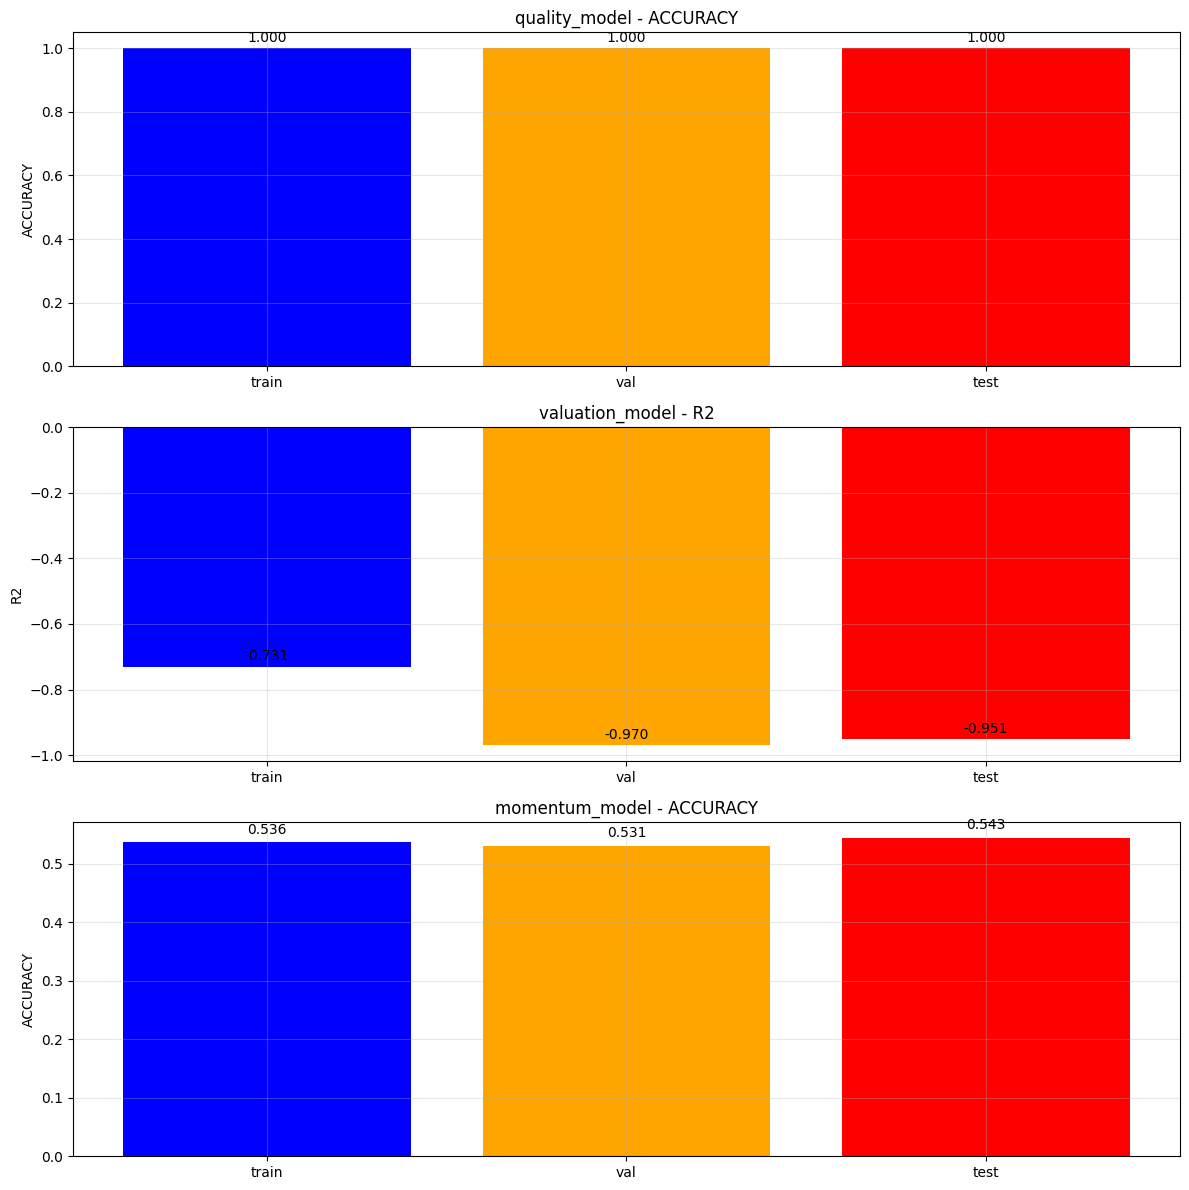


Gráfico guardado en: /content/caria_workspace/artifacts/diagnostics/overfitting_plot_20251110_222717.png


<Figure size 640x480 with 0 Axes>

In [13]:
# Visualizar gaps de overfitting
import matplotlib.pyplot as plt

if len(report["models"]) > 0:
    fig, axes = plt.subplots(len(report["models"]), 1, figsize=(12, 4 * len(report["models"])))
    if len(report["models"]) == 1:
        axes = [axes]

    for idx, (model_name, model_data) in enumerate(report["models"].items()):
        metrics = model_data["metrics"]

        # Seleccionar métrica principal según tipo de modelo
        if model_data["is_classifier"]:
            main_metric = "accuracy"
        else:
            main_metric = "r2"

        if main_metric in metrics.get("train", {}) and main_metric in metrics.get("val", {}) and main_metric in metrics.get("test", {}):
            splits = ["train", "val", "test"]
            values = [metrics[split][main_metric] for split in splits]

            axes[idx].bar(splits, values, color=["blue", "orange", "red"])
            axes[idx].set_title(f"{model_name} - {main_metric.upper()}")
            axes[idx].set_ylabel(main_metric.upper())
            axes[idx].grid(True, alpha=0.3)

            # Agregar valores en las barras
            for i, v in enumerate(values):
                axes[idx].text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

    # Guardar figura
    fig_path = output_dir / f"overfitting_plot_{timestamp_str}.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    print(f"\nGráfico guardado en: {fig_path}")
else:
    print("No hay modelos para visualizar")


## 9. Copiar Resultados a Drive (Opcional)


In [ ]:
# Copiar resultados de vuelta a Drive
drive_results_path = Path(DRIVE_BASE_PATH) / "artifacts" / "diagnostics"
drive_results_path.mkdir(parents=True, exist_ok=True)

shutil.copy2(report_path, drive_results_path / report_path.name)
if 'fig_path' in locals() and fig_path.exists():
    shutil.copy2(fig_path, drive_results_path / fig_path.name)

print(f"✓ Resultados copiados a Drive: {drive_results_path}")
